In [ ]:
pip install lime matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=7210d9122a19de8cba38bd62bc21b47871ddd42d8d2f93fb0a8c45374c1be73b
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import shap

# Load the dataset
df = pd.read_csv('Telco_customer_churn.csv')

# Drop irrelevant columns
df = df.drop(columns=['CustomerID', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Churn Reason'])

# Handle missing values in 'Total Charges'
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')
df['Total Charges'].fillna(df['Total Charges'].median(), inplace=True)

# Encode categorical features
categorical_cols = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

# Separate features and target
X = df.drop(columns=['Churn Label', 'Churn Value'])
y = df['Churn Value']

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the custom TensorFlow model
def build_custom_model():
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.3))  # Dropout to avoid overfitting
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification output

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

# Build and train the model
model = build_custom_model()
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy, auc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}, Test AUC: {auc}")

<ipython-input-1-144f3085fb79>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Total Charges'].fillna(df['Total Charges'].median(), inplace=True)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7038 - auc: 0.7199 - loss: 0.5218 - val_accuracy: 0.8836 - val_auc: 0.9476 - val_loss: 0.2719
Epoch 2/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8850 - auc: 0.9472 - loss: 0.2549 - val_accuracy: 0.9077 - val_auc: 0.9647 - val_loss: 0.2174
Epoch 3/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9132 - auc: 0.9692 - loss: 0.1985 - val_accuracy: 0.9092 - val_auc: 0.9677 - val_loss: 0.2069
Epoch 4/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9153 - auc: 0.9715 - loss: 0.1931 - val_accuracy: 0.9113 - val_auc: 0.9682 - val_loss: 0.2059
Epoch 5/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9173 - auc: 0.9747 - loss: 0.1796 - val_accuracy: 0.9163 - val_auc: 0.9690 - val_loss: 0.2011
Epoch 6/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9184 - auc: 0.9730 - loss: 0.1856 - val_accuracy: 0.9113 - val_auc: 0.9693 - val_loss: 0.2012
Epoch 7/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 

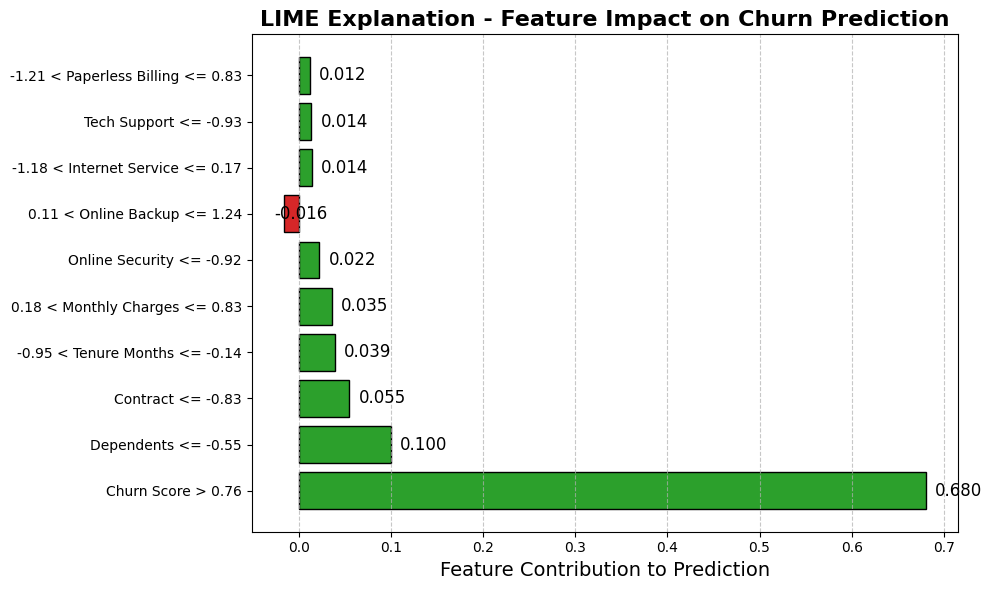

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature names and weights from LIME explanation
exp_list = exp.as_list()  # List of (feature, weight)
features = [item[0] for item in exp_list]
weights = np.array([item[1] for item in exp_list])

# Separate positive and negative contributions for color coding
colors = ['#d62728' if w < 0 else '#2ca02c' for w in weights]  # red for negative, green for positive

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(features, weights, color=colors, edgecolor='black')

plt.xlabel('Feature Contribution to Prediction', fontsize=14)
plt.title('LIME Explanation - Feature Impact on Churn Prediction', fontsize=16, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add value labels at end of bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01 * np.sign(width), bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', va='center', fontsize=12)

plt.tight_layout()
plt.show()